# Figure 4 Final

Notebook to make data for figure 4 for ms <br>
by Cascade Tuholske 2020.02.23

In [2]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [3]:
#### Load Data
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# HI DATA
FN_IN = 'processed/AllDATA-GHS-ERA5-HI406-FIGDATA.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

FN_IN = 'processed/AllDATA-GHS-ERA5-HI406-MAPDATA.csv'
MAP_DATA = pd.read_csv(DATA_IN+FN_IN)


# scale the date in the plot 
scale = 10**9 

In [4]:
#### Drop cities where P1983 == 0
print(len(HI_STATS))
HI_STATS = HI_STATS[HI_STATS['P1983'] > 0]
print(len(HI_STATS))

#### Drop cities with only one Tmax Day in 1983 and none else because you cannot regress them
#drop_list = [2543, 2560, 3667, 3669, 6122, 6156] # city ids for MERRA2 
drop_list = [832, 1732, 5521] # city IDS for ERA5

HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)]
print(len(HI_STATS))

386920
385526
385424


In [5]:
HI_STATS.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,5645,1983,1,80796.793810,80796.79381,96123.248169,80796.793810,80796.79381,0.000000
1,1,5645,1989,2,78918.494262,80796.79381,96123.248169,157836.988523,161593.58762,-3756.599097
2,2,5645,1990,3,78605.444337,80796.79381,96123.248169,235816.333011,242390.38143,-6574.048420
3,3,5645,1994,1,76481.266889,80796.79381,96123.248169,76481.266889,80796.79381,-4315.526921
4,4,5645,2005,1,80904.416534,80796.79381,96123.248169,80904.416534,80796.79381,107.622724


In [6]:
## Add In Meta Data
geog = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']
meta_fn = 'processed/AllDATA-GHS-ERA5-HI406-META.csv'
all_data = pd.read_csv(DATA_IN+meta_fn)
meta = all_data[geog]
meta = meta.drop_duplicates('ID_HDC_G0')

## Merge in meta
HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'left')

# Find Residuals for Total Days Trends

In [24]:
#### calculate Z scores for each value
def z_score(data):
    "mini function to make z scoares"
    mean = np.mean(data)
    sd = np.std(data)
    zscores = (data - mean) / sd
    
    return zscores

In [67]:
#### Let's plot the zscores for each city in India
location = 'Egypt'
geog = 'CTR_MN_NM'
#alpha = 0.05
data = HI_STATS[HI_STATS[geog] == location]
data = HI_STATS

In [68]:
years = list(np.unique(data.sort_values('year')['year']))

In [69]:
years_list = []
zscores_list = []


years = list(np.unique(data.sort_values('year')['year']))

for i, city_df in enumerate(data.groupby('ID_HDC_G0')):
    total_days = list(city_df[1].sort_values('year')['total_days'].values)
    
    # Get Data
    X_year = years
    Y_stats = total_days

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit()
    
    # residual Z scores 
    zscores = z_score(model.resid) 
    
    zscores_list.append(zscores)
    years_list.append(years)
    

Text(0, 0.5, 'z-score')

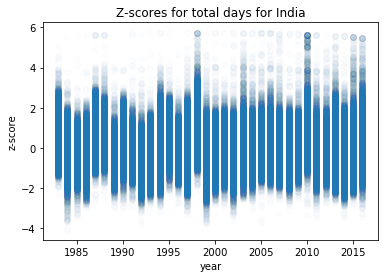

In [70]:
alpha = 0.01
plt.scatter(years_list, zscores_list, alpha = alpha)
plt.title('Z-scores for total days for'+location)
plt.xlabel('year')
plt.ylabel('z-score')

# Old Code

In [ ]:
# Make an empty data frame
years = list(np.unique(data.sort_values('year')['year']))
#cols = ['ID_HDC_G0']+years
cols = years
zscores_df = pd.DataFrame(columns = cols)

for i, city_df in enumerate(data.groupby('ID_HDC_G0')):
    row = []
#    city_id = city_df[0]
#    row.append(city_id) # get the city ids
    total_days = list(city_df[1].sort_values('year')['total_days'].values)
    zscores = z_score(total_days) 
    row = row + list(zscores) # tag on the z-scores
    row = pd.Series(row, index = zscores_df.columns)
    
    # append the df
    zscores_df = zscores_df.append(row, ignore_index=True)

In [ ]:
#### Select a Country

country = 'India'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
#data = HI_STATS[HI_STATS['ID_HDC_G0'] == 6334]

In [ ]:
X = data.sort_values('year')['year']
Y = data.sort_values('year')['total_days']

In [ ]:
data.head()

In [ ]:
#### Select a Country
country = 'China'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]

fig, axs = plt.subplots(1, 1, figsize = (7, 5), sharex=True)
line_kws = {'linestyle' : '-', 'linewidth' : 3, 'alpha' : 0.7}


for label, city in data.groupby('ID_HDC_G0'):
    X = city.sort_values('year')['year']
    Y = city.sort_values('year')['total_days']
    
    # set alphas 
    
    plt.plot(X,Y, alpha = 0.05, color = 'gray') #'lavender')

X = data.sort_values('year')['year']
Y = data.sort_values('year')['total_days']
sns.regplot(X, Y, color = 'purple', scatter = False, truncate = True, line_kws = line_kws)

#### Select a Country
# country = 'Indonesia'
# data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
# X = data.sort_values('year')['year']
# Y = data.sort_values('year')['total_days']

# for label, city in data.groupby('ID_HDC_G0'):
#     X = city.sort_values('year')['year']
#     Y = city.sort_values('year')['total_days']
    
#     plt.plot(X,Y, alpha = 0.05, color = 'palegreen')
    
# X = data.sort_values('year')['year']
# Y = data.sort_values('year')['total_days']
# sns.regplot(X, Y, color = 'darkgreen', scatter = False, truncate = True, line_kws = line_kws, label = 'Egypt')
    
#plt.ylim([0,25])#### Select a Country
plt.title(country+' Total Days per Year HI > 40.6 C')
plt.ylabel('Days/yr HI > 40.6')

In [ ]:
#### Select a Country
fig, axs = plt.subplots(1, 1, figsize = (7, 5), sharex=True)
line_kws = {'linestyle' : ':'}

country = 'India'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X = data['year']
Y = data['total_days']

plt.scatter(X,Y, alpha = 0.002)#, s = 20, marker = '.')
sns.regplot(X, Y, color = 'purple', scatter = False, truncate = True, line_kws = line_kws)
#plt.ylim([0,1])

In [ ]:
len(np.unique(data['ID_HDC_G0']))

# Check Total Days > 365

In [ ]:
#### Select a Country
country = 'Indonesia'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]

In [ ]:
data[data['total_days']> 365]

In [ ]:
alldata = pd.read_csv(DATA_IN+'processed/All_data_HI406_meta.csv')

In [ ]:
alldata.head()

In [ ]:
list(alldata[(alldata['year'] == 1997) & (alldata['ID_HDC_G0'] == 11423)]['event_dates'])

In [7]:
#### Select a city in India
data = HI_STATS[HI_STATS['ID_HDC_G0'] == 6334]

In [8]:
X = data.sort_values('year')['year']
Y = data.sort_values('year')['total_days']

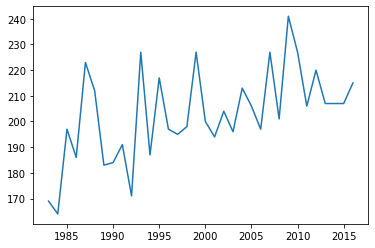

In [9]:
plt.plot(X,Y)

(array([3., 0., 4., 2., 8., 6., 4., 2., 4., 1.]),
 array([164. , 171.7, 179.4, 187.1, 194.8, 202.5, 210.2, 217.9, 225.6,
        233.3, 241. ]),
 <a list of 10 Patch objects>)

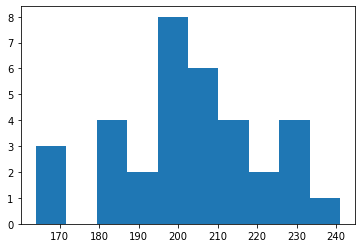

In [10]:
plt.hist(Y)

In [11]:
mean = np.mean(Y)
SD = np.std(Y)
zscores = (Y - mean)/SD

In [12]:
#### calculate Z scores for each value
def z_score(data):
    "mini function to make z scoares"
    mean = np.mean(data)
    sd = np.std(data)
    zscores = (data - mean) / sd
    
    return zscores

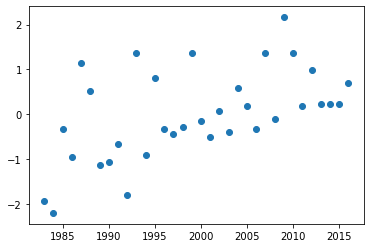

In [13]:
plt.scatter(X, zscores)

In [ ]:
#### Let's plot the zscores for each city in India
country = 'Nigeria'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]

In [ ]:
years = list(np.unique(data.sort_values('year')['year']))
cols = ['ID_HDC_G0']+years
zscores_df = pd.DataFrame(columns = cols)

In [ ]:
years_list = []
zscores_list = []

years = list(np.unique(data.sort_values('year')['year']))

for i, city_df in enumerate(data.groupby('ID_HDC_G0')):
    total_days = list(city_df[1].sort_values('year')['total_days'].values)
    zscores = z_score(total_days) 
    zscores_list.append(zscores)
    years_list.append(years)


In [ ]:
plt.scatter(years_list, zscores_list, alpha = 0.05)
plt.title('Z-scores for total days for India')
plt.xlabel('year')
plt.ylabel('z-score')

In [ ]:
coef_totdays = pd.read_csv(DATA_IN+'processed/AllDATA-GHS-ERA5-HI406-MAPDATA_TOTDAYS_P05.csv')
coef_totdays.columns

In [ ]:
data = coef_totdays[coef_totdays['CTR_MN_NM'] == 'India'][['ID_HDC_G0','coef_totDays']]

In [ ]:
data

In [ ]:
#### Select a city in India
city = HI_STATS[HI_STATS['ID_HDC_G0'] == 6334]
slope = data[data['ID_HDC_G0'] == 6334]['coef_totDays'].values[0]

In [ ]:
city = city[['year', 'total_days']]

In [ ]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 
    
"simple linear model of a time series data, returns coef"

# Get Data
X_year = city['year']
Y_stats = city['total_days']

# Add Intercept
X_year_2 = sm.add_constant(X_year)

# Regress
model = sm.OLS(Y_stats, X_year_2).fit() 

# coef = int(model.params[1]*scale)
# #coef = int(coef)

# # R2 and P
# r2 = model.rsquared_adj
# p = model.pvalues[0]

# return coef, round(r2, 2), round(p, 3)

In [ ]:
city['res'] = model.resid

In [ ]:
city['predict'] = city['total_days'] - city['res']

In [ ]:
predict_model = model.predict()

In [ ]:
len(city['year'])

In [ ]:
plt.plot(city['year'], city['total_days'], color = 'red')
plt.scatter(city['year'], city['predict'], color = 'blue')
plt.scatter(city['year'], predict_model, color = 'green')

In [ ]:
predict = model.predict()

In [ ]:
city['model_predict'] = predict

In [ ]:
city['zscores'] = z_score(city['res'])

In [ ]:
plt.plot(city['year'], city['zscores'])
plt.plot(city['year'], city['total_days'], color = 'red')



In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('year')
ax1.set_ylabel('days', color=color)
ax1.plot(city['year'], city['total_days'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('z-score', color=color)  # we already handled the x-label with ax1
ax2.plot(city['year'], city['zscores'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()